# 2 Evaluation of the Optimal CNN on Season 5 Data

This notebook focuses on the assessment of the optimal CNN configuration, which was identified based on its performance with season 4 data. The evaluation is extended to a newly acquired dataset from season 5. The parameters defining this optimal configuration are detailed in the sections below.

In [1]:
# MODEL: C134
PREPROCESSING = "mishra_adj"
SET_SPLIT = "mishra"
TRAINING_ORDER = "mishra"
TRAINING_DATASET = "cal"
INCLUDE_MISHRA_OUTLIERS = False
X_SCALED = True

## 1.0 Setup

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from utils import models
from utils import evaluation

In [3]:
# set random seeds for Python, NumPy, and TensorFlow
seed_value = 42
os.environ["PYTHONHASHSEED"] = "0"
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

params = {
    "preprocessing": PREPROCESSING,
    "set_split": SET_SPLIT,
    "training_order": TRAINING_ORDER,
    "include_mishra_outliers": INCLUDE_MISHRA_OUTLIERS,
    "x_scaled": X_SCALED,
}

### 1.1 Prepare Dataset

In [4]:
# prepare data based on set parameters above

# read in data that has been preprocessed
if PREPROCESSING == "anderson":
    data_file = "data/input/season_1_to_4/anderson&etal_2020_pretreatment.csv"
    data_file_2 = "data/input/season_5/anderson&etal_2020_pretreatment.csv"
elif PREPROCESSING == "mishra":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment.csv"
    data_file_2 = "data/input/season_5/mishra&passos_2021_pretreatment.csv"
elif PREPROCESSING == "mishra_adj":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment_adjusted.csv"
    data_file_2 = "data/input/season_5/mishra&passos_2021_pretreatment_adjusted.csv"
elif PREPROCESSING == "raw":
    data_file = "data/input/season_1_to_4/nil_pretreatment.csv"
    data_file_2 = "data/input/season_5/mishra&nil_pretreatment.csv"
else:
    raise Exception("choose a valid preprocessing")
test_data = pd.read_csv(data_file_2).drop(columns=["Unnamed: 0"])
data = pd.read_csv(data_file).drop(columns=["Unnamed: 0"])
data.insert(0, "sample_order", 0)
data.insert(1, "sample_no", 0)
data.insert(2, "set", 0)

# include or exclude mishra outliers
if not INCLUDE_MISHRA_OUTLIERS:
    data = data.query("set_mishra != 'Outlier'").copy()

# assign set split
if SET_SPLIT == "anderson":
    data["sample_no"] = data["sample_no_anderson"]
    data["set"] = data["set_anderson"]
elif SET_SPLIT == "mishra" and not INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra"]
    data["set"] = data["set_mishra"]
elif SET_SPLIT == "mishra_with_outliers" and INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra_with_outliers"]
    data["set"] = data["set_mishra_with_outliers"]
else:
    raise Exception("choose a valid set split")

# order data based on ordering selection
if TRAINING_ORDER == "mishra" and SET_SPLIT == "mishra_with_outliers":
    TRAINING_ORDER = "mishra_with_outliers"
elif TRAINING_ORDER == "mishra_with_outliers" and SET_SPLIT == "mishra":
    TRAINING_ORDER = "mishra"
data.sort_values(by=f"sample_no_{TRAINING_ORDER}", inplace=True)
data.reset_index(inplace=True, drop=True)
data["sample_order"] = data.index + 1

data.groupby(["category", "set"]).size()

category  set    
Test      Val Ext    1448
Train     Cal        6642
          Tuning     3272
dtype: int64

In [5]:
data

,sample_order,sample_no,set,category,sample_no_anderson,set_anderson,sample_no_mishra,set_mishra,sample_no_mishra_with_outliers,set_mishra_with_outliers,...,963_snv_savgol_w13_p2_d2,966_snv_savgol_w13_p2_d2,969_snv_savgol_w13_p2_d2,972_snv_savgol_w13_p2_d2,975_snv_savgol_w13_p2_d2,978_snv_savgol_w13_p2_d2,981_snv_savgol_w13_p2_d2,984_snv_savgol_w13_p2_d2,987_snv_savgol_w13_p2_d2,990_snv_savgol_w13_p2_d2
0,1,1,Cal,Train,4056,Cal,1,Cal,1,Cal,...,-0.007892,-0.007631,-0.006871,-0.005841,-0.004806,-0.003989,-0.003466,-0.003130,-0.002887,-0.002637
1,2,2,Cal,Train,4504,Cal,2,Cal,2,Cal,...,-0.005398,-0.005191,-0.004671,-0.004030,-0.003412,-0.002911,-0.002519,-0.002223,-0.002044,-0.001813
2,3,3,Cal,Train,1244,Cal,3,Cal,3,Cal,...,-0.006159,-0.006081,-0.005512,-0.004685,-0.003894,-0.003345,-0.003032,-0.002733,-0.002426,-0.002328
3,4,4,Cal,Train,5131,Cal,4,Cal,4,Cal,...,-0.005634,-0.005499,-0.004965,-0.004244,-0.003562,-0.003039,-0.002701,-0.002492,-0.002378,-0.002295
4,5,5,Cal,Train,2745,Cal,5,Cal,6,Cal,...,-0.006629,-0.006367,-0.005627,-0.004745,-0.003942,-0.003334,-0.002923,-0.002585,-0.002263,-0.002113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11357,11358,11358,Val Ext,Test,11687,Val Ext,11358,Val Ext,11687,Val Ext,...,-0.007797,-0.007829,-0.007283,-0.006387,-0.005479,-0.004731,-0.004156,-0.003735,-0.003378,-0.002993
11358,11359,11359,Val Ext,Test,11688,Val Ext,11359,Val Ext,11688,Val Ext,...,-0.007817,-0.007876,-0.007312,-0.006454,-0.005559,-0.004746,-0.004095,-0.003653,-0.003342,-0.003045
11359,11360,11360,Val Ext,Test,11689,Val Ext,11360,Val Ext,11689,Val Ext,...,-0.007943,-0.007985,-0.007451,-0.006553,-0.005612,-0.004820,-0.004229,-0.003823,-0.003468,-0.003137
11360,11361,11361,Val Ext,Test,11690,Val Ext,11361,Val Ext,11690,Val Ext,...,-0.007985,-0.008064,-0.007564,-0.006701,-0.005800,-0.005059,-0.004472,-0.003947,-0.003558,-0.003190


In [6]:
test_data

,season,region,date,year,type,cultivar,pop,temp,dm,684_absorbance,...,963_snv_savgol_w13_p2_d2,966_snv_savgol_w13_p2_d2,969_snv_savgol_w13_p2_d2,972_snv_savgol_w13_p2_d2,975_snv_savgol_w13_p2_d2,978_snv_savgol_w13_p2_d2,981_snv_savgol_w13_p2_d2,984_snv_savgol_w13_p2_d2,987_snv_savgol_w13_p2_d2,990_snv_savgol_w13_p2_d2
0,5,NT,2019-09-11,2019,Hard Green,R2E2,128,No,19.20653,0.612291,...,-0.007050,-0.007141,-0.006626,-0.005735,-0.004784,-0.004039,-0.003610,-0.003353,-0.002961,-0.002528
1,5,NT,2019-09-11,2019,Hard Green,R2E2,128,No,19.20653,0.616778,...,-0.007109,-0.007145,-0.006578,-0.005674,-0.004775,-0.004108,-0.003674,-0.003291,-0.002862,-0.002493
2,5,NT,2019-09-11,2019,Hard Green,R2E2,128,No,19.00393,0.565043,...,-0.006743,-0.006636,-0.006078,-0.005358,-0.004670,-0.004055,-0.003464,-0.002961,-0.002653,-0.002488
3,5,NT,2019-09-11,2019,Hard Green,R2E2,128,No,19.00393,0.566439,...,-0.006659,-0.006703,-0.006208,-0.005426,-0.004625,-0.003959,-0.003459,-0.003056,-0.002701,-0.002390
4,5,NT,2019-09-11,2019,Hard Green,R2E2,128,No,16.89858,0.595393,...,-0.007774,-0.007770,-0.007195,-0.006266,-0.005298,-0.004508,-0.003912,-0.003480,-0.003156,-0.002829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,5,NT,2019-09-18,2019,Hard Green,KP,129,No,14.55153,0.756579,...,-0.006231,-0.006189,-0.005715,-0.004983,-0.004227,-0.003622,-0.003205,-0.002886,-0.002620,-0.002362
316,5,NT,2019-09-18,2019,Hard Green,KP,129,No,14.88015,0.760855,...,-0.006261,-0.006230,-0.005733,-0.005000,-0.004252,-0.003605,-0.003115,-0.002787,-0.002529,-0.002300
317,5,NT,2019-09-18,2019,Hard Green,KP,129,No,14.88015,0.761702,...,-0.005948,-0.006009,-0.005568,-0.004858,-0.004142,-0.003510,-0.002999,-0.002662,-0.002424,-0.002072
318,5,NT,2019-09-18,2019,Hard Green,KP,129,No,14.60877,0.764641,...,-0.006029,-0.005953,-0.005513,-0.004793,-0.004038,-0.003469,-0.003072,-0.002730,-0.002498,-0.002271


In [7]:
# split into train and test
dfs = {
    "train": data.query("set.isin(['Cal', 'Tuning'])").copy(),
    "cal": data.query("set == 'Cal'").copy(),
    "tune": data.query("set == 'Tuning'").copy(),
    # "test": data.query("set == 'Val Ext'").copy(),
    "test": test_data.copy()
}
d = {}

# get the x columns by getting columns that start with int
x_cols = data.filter(regex="^\d+", axis=1).columns.tolist()
if PREPROCESSING == "raw":
    x_cols = [c for c in x_cols if "absorbance" in c]

# convert to numpy arrays
for s in ("train", "cal", "tune", "test"):
    d[f"y_{s}"] = dfs[s]["dm"].to_numpy().reshape(-1, 1)
    d[f"x_{s}_raw"] = dfs[s][x_cols].to_numpy()
    print(f"""
    {s} set:
        X = {d[f"x_{s}_raw"].shape}
        Y = {d[f"y_{s}"].shape}"""
    )


    train set:
        X = (9914, 618)
        Y = (9914, 1)

    cal set:
        X = (6642, 618)
        Y = (6642, 1)

    tune set:
        X = (3272, 618)
        Y = (3272, 1)

    test set:
        X = (320, 618)
        Y = (320, 1)


### 1.2 Standardise Data

In [8]:
# train scaler using the entire training set
scaler = StandardScaler()
scaler.fit(X=d["x_train_raw"])

# apply scalar to training and test set
for s in ("train", "cal", "tune", "test"):
    d[f"x_{s}_scaled"] = scaler.transform(d[f"x_{s}_raw"])
    d[f"x_{s}"] = d[f"x_{s}_scaled"] if X_SCALED else d[f"x_{s}_raw"]

## 2.0 Build Models

### 2.3 CNN Mishra & Passos (2021)

Epoch 1/750
52/52 [==============================] - 3s 22ms/step - loss: 27.7095 - mse: 26.8228 - val_loss: 5.4766 - val_mse: 4.5143 - lr: 0.0050
Epoch 2/750
52/52 [==============================] - 1s 19ms/step - loss: 3.8364 - mse: 2.8744 - val_loss: 3.3786 - val_mse: 2.4275 - lr: 0.0050
Epoch 3/750
52/52 [==============================] - 1s 16ms/step - loss: 2.8524 - mse: 1.9185 - val_loss: 2.7680 - val_mse: 1.8535 - lr: 0.0050
Epoch 4/750
52/52 [==============================] - 1s 16ms/step - loss: 2.3816 - mse: 1.4868 - val_loss: 2.3948 - val_mse: 1.5214 - lr: 0.0050
Epoch 5/750
52/52 [==============================] - 1s 17ms/step - loss: 2.1049 - mse: 1.2516 - val_loss: 2.0391 - val_mse: 1.2070 - lr: 0.0050
Epoch 6/750
52/52 [==============================] - 1s 17ms/step - loss: 1.8227 - mse: 1.0115 - val_loss: 1.8114 - val_mse: 1.0231 - lr: 0.0050
Epoch 7/750
52/52 [==============================] - 1s 15ms/step - loss: 1.6256 - mse: 0.8569 - val_loss: 1.6486 - val_mse: 0.9

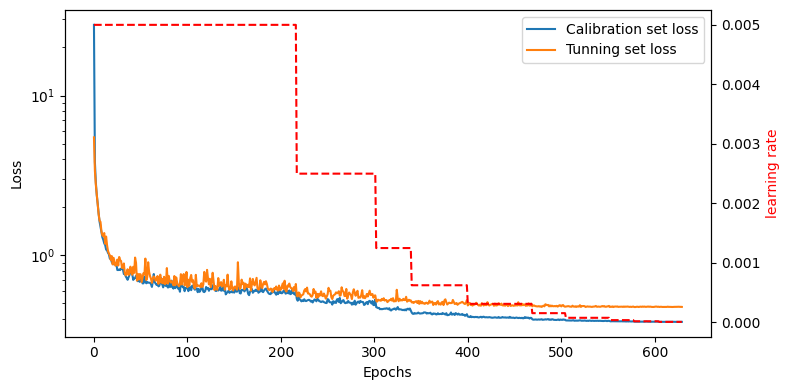

In [9]:
if TRAINING_DATASET == "train":
    model_cnn, meta_cnn = models.build_cnn(
        x_train=d["x_train"],
        y_train=d["y_train"],
    )
else:
    model_cnn, meta_cnn = models.build_cnn(
        x_train=d["x_cal"],
        y_train=d["y_cal"],
        x_val=d["x_tune"],
        y_val=d["y_tune"],
    )

## 3.0 Test model on new populations

10/10 [==============================] - 0s 4ms/step


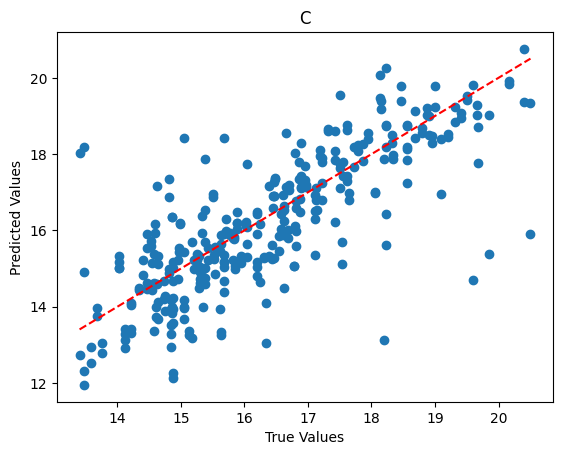

In [10]:
df = pd.DataFrame(
    data={
        "y_true": d[f"y_test"].flatten(),
        "y_pred": model_cnn.predict(d[f"x_test"]).flatten(),
    }
)

# calculate r-squared value
r2 = r2_score(df["y_true"], df["y_pred"])

# create a scatter plot
plt.scatter(df["y_true"], df["y_pred"], label=f"R2 = {r2:.2f}")
plt.plot([min(df["y_true"]), max(df["y_true"])], [min(df["y_true"]), max(df["y_true"])], linestyle='--', color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("C")
plt.show()

In [11]:
df

,y_true,y_pred
0,19.20653,18.530565
1,19.20653,18.459255
2,19.00393,19.227974
3,19.00393,19.782700
4,16.89858,17.125923
...,...,...
315,14.55153,14.435379
316,14.88015,14.672673
317,14.88015,14.238772
318,14.60877,13.990947
